## Import

In [3]:
import torch
import numpy as np
import torchvision
from matplotlib import pyplot as plt
import torch.nn as nn
from copy import deepcopy
# c = np.random.randn(3,2)
# c=np.clip(a_min=-2.0,a_max=2.0,a=c)
def labels(x,c):
    
    d=c-x
    d=np.clip(a_min=-0.5,a_max=0.5,a=d)-d
    
    for i in d:
        if i[0]==0 and i[1]==0:
             return(1)
    else: return(0)
    
    
    

## Labeller

In [4]:
def labels(x,c):
    
    d=c-x
    d=np.clip(a_min=-0.5,a_max=0.5,a=d)-d
    
    for i in d:
        if i[0]==0 and i[1]==0:
             return(1)
    else: return(0)
    
    
    

## Create Rooms

In [19]:
c_rooms = np.random.randn(20,3,2)
c_rooms=np.clip(a_min=-2.0,a_max=2.0,a=c_rooms)
xc=np.random.randint(low=-230,high=230,size=(20,3000,2))/100
yc = np.zeros((20,3000))
for i in range(20):
    for j in range(3000):
        yc[i,j] = labels(xc[i,j,:],c_rooms[i])

## Plot Rooms

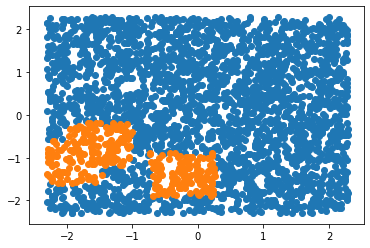

In [22]:
zero=[]
one=[]
for i in xc[0]:
    if labels(i,c_rooms[0])==0:
        zero.append(i)
    else: one.append(i)

plt.scatter(np.array(zero)[:,0],np.array(zero)[:,1]) 
plt.scatter(np.array(one)[:,0],np.array(one)[:,1])
    

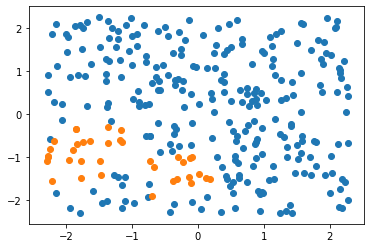

In [21]:
#Train data:
zero=[]
one=[]
for i in xc[0][:300]:
    if labels(i,c_rooms[0])==0:
        zero.append(i)
    else: one.append(i)

plt.scatter(np.array(zero)[:,0],np.array(zero)[:,1]) 
plt.scatter(np.array(one)[:,0],np.array(one)[:,1])


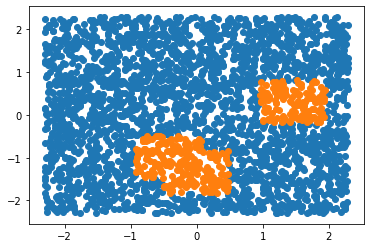

In [29]:
zero=[]
one=[]
for i in xc[1]:
    if labels(i,c_rooms[1])==0:
        zero.append(i)
    else: one.append(i)

plt.scatter(np.array(zero)[:,0],np.array(zero)[:,1]) 
plt.scatter(np.array(one)[:,0],np.array(one)[:,1])
    

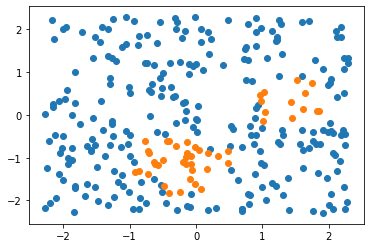

In [30]:
zero=[]
one=[]
for i in xc[1][:300]:
    if labels(i,c_rooms[1])==0:
        zero.append(i)
    else: one.append(i)

plt.scatter(np.array(zero)[:,0],np.array(zero)[:,1]) 
plt.scatter(np.array(one)[:,0],np.array(one)[:,1])

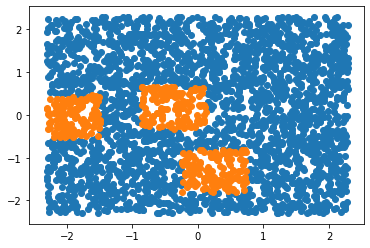

In [31]:
zero=[]
one=[]
for i in xc[1]:
    if labels(i,c_rooms[2])==0:
        zero.append(i)
    else: one.append(i)

plt.scatter(np.array(zero)[:,0],np.array(zero)[:,1]) 
plt.scatter(np.array(one)[:,0],np.array(one)[:,1])
    

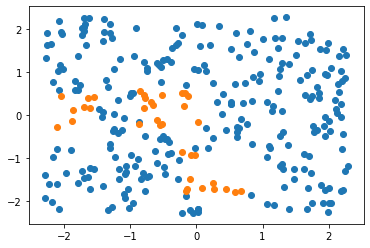

In [32]:
zero=[]
one=[]
for i in xc[2][:300]:
    if labels(i,c_rooms[2])==0:
        zero.append(i)
    else: one.append(i)

plt.scatter(np.array(zero)[:,0],np.array(zero)[:,1]) 
plt.scatter(np.array(one)[:,0],np.array(one)[:,1])
    

## FCN with meta-training

In [42]:
class FCN(nn.Module):

    def __init__(self):
        
        super(FCN, self).__init__()
        self.features=nn.Sequential(  # 60x60
            nn.Linear(2,20),  # 58x58
            nn.ReLU(True),
            nn.Linear(20,30),  # 56x56
            nn.ReLU(True),
            nn.Linear(30,20),  # 28x28
            nn.ReLU(True),
            nn.Linear(20,1)

        )  
        self.optimizer = torch.optim.SGD(self.parameters(),lr = 0.01)
        def init_weights(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform(m.weight)
                m.bias.data.fill_(0.01)
        
        self.features.apply(init_weights)
        self.meta_dict = self.state_dict()

    def forward(self,x):
        y = (self.features(x))
        out = torch.cat((y,-y),1)
        return(torch.cat((y,-y),1))
    
    def train_step(self,xc,yc):
#        for i in range(15):
            data=torch.tensor(xc).float()
            pred = self.forward(data)
            label=torch.tensor(yc)
            criterion= nn.CrossEntropyLoss()
            loss = criterion(pred,label.long())
            loss.backward()
            
            self.optimizer.step()
            return(loss)
            #loss.backward()
            
    def train_meta(self,xc,yc):
        #empty gradient of loss
        temp_dict = deepcopy(self.meta_dict)
        for i in temp_dict.keys():
            temp_dict[i] *= 0
            
        for i in range(3):
            #load parameters
            self.load_state_dict(self.meta_dict)
            #obtain directed params
            self.train_step(xc[i],yc[i])
            #sample new points
            xc_new= np.random.randint(low=-230,high=230,size=(200,2))/100
            yc_new = np.zeros(200)
            for j in range(200):
                yc_new[j] = labels(xc[i,j,:],c_rooms[i])
            pred = self.forward(torch.tensor(xc_new).float())
            label=torch.tensor(yc_new)
            criterion= nn.CrossEntropyLoss()
            loss = criterion(pred,label.long())
            loss.backward()
            temp = list(self.parameters())
            #save the gradients
            for j,i in enumerate(temp_dict.keys()):
                temp_dict[i] += temp[j].grad
        for i in temp_dict.keys():
            self.meta_dict[i] = temp_dict[i]*0.002
        print(temp_dict[i])    
           
            

In [43]:
A = FCN()

/home/abhi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [44]:
xc.shape

(20, 3000, 2)

In [45]:
for i in range(100):
    A.train_meta(xc[:,:600,:],yc[:,:600])

tensor([-9.5466])
tensor([-22.3843])
tensor([-35.6626])
tensor([-49.0133])
tensor([-62.4400])
tensor([-75.9426])
tensor([-89.5207])
tensor([-103.1737])
tensor([-116.9010])
tensor([-130.7014])
tensor([-144.5736])
tensor([-158.5163])
tensor([-172.5276])
tensor([-186.6057])
tensor([-200.7485])
tensor([-214.9536])
tensor([-229.2186])
tensor([-243.5408])
tensor([-257.9176])
tensor([-272.3460])
tensor([-286.8230])
tensor([-301.3456])
tensor([-315.9105])
tensor([-330.5147])
tensor([-345.1550])
tensor([-359.8281])
tensor([-374.5308])
tensor([-389.2600])
tensor([-404.0124])
tensor([-418.7850])
tensor([-433.5749])
tensor([-448.3792])
tensor([-463.1948])
tensor([-478.0191])
tensor([-492.8496])
tensor([-507.6837])
tensor([-522.5190])
tensor([-537.3534])
tensor([-552.1846])
tensor([-567.0106])
tensor([-581.8297])
tensor([-596.6400])
tensor([-611.4399])
tensor([-626.2280])
tensor([-641.0029])
tensor([-655.7632])
tensor([-670.5081])
tensor([-685.2363])
tensor([-699.9470])
tensor([-714.6393])
tensor([

# Does not converge!

## Plot Prediction

In [ ]:
zero=[]
one=[]
for j,i in enumerate(A.forward(torch.tensor(xc[0]).float())):
    if i[0]>0:
        zero.append(xc[0][j])
    else: one.append(xc[0][j])

plt.scatter(np.array(zero)[:,0],np.array(zero)[:,1]) 
plt.scatter(np.array(one)[:,0],np.array(one)[:,1])
    